In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Wrapper class for scalar values

That will allow us build mathematical expresions using basic operations with information about what values created them with what operation. It will allow us to build a graph of operations and then calculate gradients using backpropagation.

In [11]:
class Value:
    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.gradient = 0.0
        # function which will do local chain rule gradient calculation
        self._backward = lambda: None
        self.children = set(children)
        self.operation = operation
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, children={self.children}, op='{self.operation}')"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.gradient = 1 * out.gradient
            other.gradient = 1 * out.gradient
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.gradient = other.data * out.gradient
            other.gradient = self.data * out.gradient
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.gradient = (1 - t**2) * out.gradient
        out._backward = _backward
        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(value):
            if value not in visited:
                visited.add(value)
                for child in value.children:
                    build_topo(child)
                topo.append(value)
        build_topo(self)
        
        # go one variable at a time and apply the chain rule to get its gradient
        self.gradient = 1
        for value in reversed(topo):
            value._backward()         

### Simple mathematical expresion using our wrapper class

In [12]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
d = Value(-2.0, label = 'd')
ab = a*b; ab.label = 'ab'
abc = ab+c; abc.label = 'abc'
L = abc*d; L.label = 'L' # L = (a*b+c)*d

### Manual backpropagation
Caluclation of derivatives for L in respect to a, b, c, d using chain rule

In [13]:
# dL/dL
L.gradient = 1.0
# dL/dabc
abc.gradient = d.data
# dL/dd
d.gradient = abc.data
# dL/ab = dL/dabc * dabc/dab
ab.gradient = abc.gradient * 1
# dL/dc = dL/dabc * dabc/dc
c.gradient = abc.gradient * 1
# dL/da = dL/dab * dab/da
a.gradient = ab.gradient * b.data
# dL/db = dL/dab * dab/db
b.gradient = ab.gradient * a.data

### Visualization of simple forward pass

Forward pass refers to the process of propagating input data through the network's layers to produce an output prediction

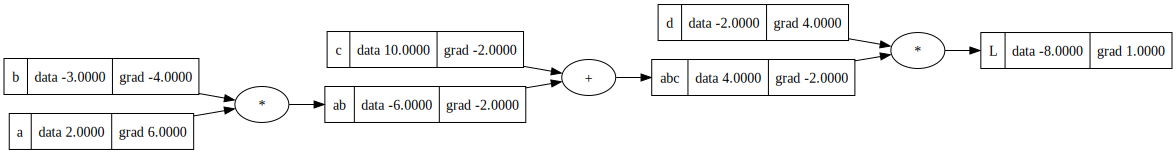

In [14]:
from ipynb.fs.full.draw import draw_dot

draw_dot(L)

### Neuron representation in Convolutional Neural Network
![Neuron](neuron.jpeg)

### Neuron implementation

In [19]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias b
b = Value(6.8813735870195432, label = 'b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
# activation function input
n = x1w1x2w2 + b; n.label = 'n'
output = n.tanh(); output.label = 'output'

In [16]:
# manual backprogation - point of intrest are gradients of w1 and w2, because we will adjust them in training process
output.gradient = 1.0
n.gradient = output.gradient * (1 - output.data**2)
x1w1x2w2.gradient = n.gradient * 1
b.gradient = n.gradient * 1
x1w1.gradient = x1w1x2w2.gradient * 1
x2w2.gradient = x1w1x2w2.gradient * 1
w1.gradient = x1w1.gradient * x1.data
w2.gradient = x2w2.gradient * x2.data
x1.gradient = x1w1.gradient * w1.data
x2.gradient = x2w2.gradient * w2.data

In [21]:
# automatic backprogation
output.backward()

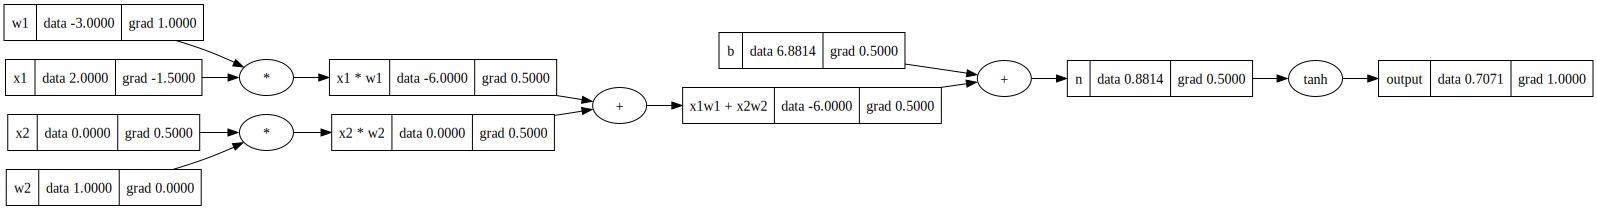

In [22]:
draw_dot(output)